## TJ Zhang

### set up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from census import Census
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as sps
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNetCV,LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error,accuracy_score,precision_score,classification_report,confusion_matrix,make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from string import digits

import warnings
warnings.filterwarnings("ignore")

### Load and Prepare Data (20%)

In [2]:
from pathlib import Path
articles = pd.DataFrame.from_records(
    ((f.parent.name, f.name, f.read_text(encoding='latin1'))
     for f in Path('bbc').glob('*/*.txt')),
    columns=['category', 'file', 'text']
)

In [3]:
articles.head()

,category,file,text
0,entertainment,289.txt,Musicians to tackle US red tape\n\nMusicians' ...
1,entertainment,262.txt,"U2's desire to be number one\n\nU2, who have w..."
2,entertainment,276.txt,Rocker Doherty in on-stage fight\n\nRock singe...
3,entertainment,060.txt,Snicket tops US box office chart\n\nThe film a...
4,entertainment,074.txt,Ocean's Twelve raids box office\n\nOcean's Twe...


### split the data

In [4]:
train, test = train_test_split(articles, test_size=0.2, random_state=12345)

<AxesSubplot:>

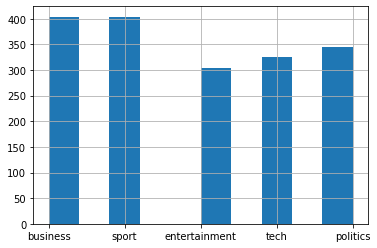

In [5]:
train['category'].hist()

histogram can do good job in showing the distribution of the data. and we can see that the total number of these five categories are similar. and number of entertament, tech and politics are little lower than number of business and sport.

### Classification (25%)

#### naïve Bayes

In [6]:
bayes_pipe = Pipeline([
    ('word_count', CountVectorizer()),
    ('classify', MultinomialNB())
])
bayes_pipe.fit(train['text'], train['category'])

Pipeline(steps=[('word_count', CountVectorizer()),
                ('classify', MultinomialNB())])

In [7]:
accuracy_score(train['category'],bayes_pipe.predict(train['text']))

0.9926966292134831

In [8]:
accuracy_score(test['category'],bayes_pipe.predict(test['text']))

0.9797752808988764

naïve Bayes model is based on the feature word_count, and the accuracy is quite high.

#### KNN

KNN classifier with 5 neighbors on TF-IDF term vectors

In [9]:
knn_pipe=Pipeline([
    
    ('TF-IDF term vectors',TfidfVectorizer()),
#     ('model',GridSearchCV(KNeighborsClassifier(), {
#     'n_neighbors': [1, 2, 3, 5, 7, 10]
# }, scoring=make_scorer(accuracy_score)))
    ('model',KNeighborsClassifier(n_neighbors=5))
])
knn_pipe.fit(train['text'], train['category'])

Pipeline(steps=[('TF-IDF term vectors', TfidfVectorizer()),
                ('model', KNeighborsClassifier())])

In [10]:
accuracy_score(train['category'],knn_pipe.predict(train['text']))

0.950561797752809

In [11]:
accuracy_score(test['category'],knn_pipe.predict(test['text']))

0.8921348314606742

a k-NN classifier with GridSearchCV to pick the neighborhood size

In [12]:
GS_knn_pipe=Pipeline([
    
    ('TF-IDF term vectors',TfidfVectorizer()),
    ('model',GridSearchCV(KNeighborsClassifier(), {
    'n_neighbors': [1, 2, 3, 5, 7, 10]
}, n_jobs=6,scoring=make_scorer(accuracy_score)))
    #('model',KNeighborsClassifier())
])
GS_knn_pipe.fit(train['text'], train['category'])

Pipeline(steps=[('TF-IDF term vectors', TfidfVectorizer()),
                ('model',
                 GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=6,
                              param_grid={'n_neighbors': [1, 2, 3, 5, 7, 10]},
                              scoring=make_scorer(accuracy_score)))])

In [13]:
GS_knn_pipe.named_steps['model'].best_params_

{'n_neighbors': 5}

In [14]:
accuracy_score(train['category'],GS_knn_pipe.predict(train['text']))

0.950561797752809

In [15]:
accuracy_score(test['category'],GS_knn_pipe.predict(test['text']))

0.8921348314606742

### Dimensionality Reduction (15%)

search for neighbors in a vector space with reduced dimension, using TruncatedSVD

In [16]:
from sklearn.decomposition import TruncatedSVD
svd_pipe = Pipeline([
    ('word_vec', TfidfVectorizer()),
    ('svd', TruncatedSVD(8))
])
svd_pipe.fit(train['text'])
text_vectors = svd_pipe.transform(train['text'])
text_vectors

array([[ 0.2234182 , -0.06769252, -0.07571529, ..., -0.01474666,
        -0.00980095,  0.0686331 ],
       [ 0.40025378, -0.13055054, -0.14446495, ..., -0.1407591 ,
        -0.12328169, -0.02326503],
       [ 0.22722123, -0.06547023,  0.09423075, ...,  0.11259031,
        -0.16231318,  0.02252916],
       ...,
       [ 0.50544132, -0.08227313,  0.09876317, ..., -0.0136678 ,
         0.00737828,  0.05141192],
       [ 0.3232912 , -0.09786951, -0.07688236, ..., -0.0660169 ,
        -0.04270558,  0.04317688],
       [ 0.42855618,  0.00053186, -0.09016219, ...,  0.02905464,
         0.02977766, -0.08697798]])

convert from ndarray to dataframe

In [17]:
text_vectors1=pd.DataFrame(text_vectors)
text_vectors1['category']=train.reset_index()['category']
text_vectors1

,0,1,2,3,4,5,6,7,category
0,0.223418,-0.067693,-0.075715,0.035404,-0.083799,-0.014747,-0.009801,0.068633,business
1,0.400254,-0.130551,-0.144465,0.185228,-0.198767,-0.140759,-0.123282,-0.023265,business
2,0.227221,-0.065470,0.094231,0.073667,-0.028196,0.112590,-0.162313,0.022529,sport
3,0.266463,-0.002137,0.243206,-0.047374,-0.150104,-0.133019,0.067652,-0.068188,sport
4,0.463347,-0.009591,-0.075788,-0.032857,0.012452,0.008995,-0.005822,-0.053395,entertainment
...,...,...,...,...,...,...,...,...,...
1775,0.285157,-0.022817,-0.070976,-0.060029,0.020716,0.054290,0.010615,-0.147420,tech
1776,0.342924,-0.089379,-0.129245,0.121333,-0.181535,-0.111493,-0.069735,-0.002065,business
1777,0.505441,-0.082273,0.098763,0.004496,0.139824,-0.013668,0.007378,0.051412,entertainment
1778,0.323291,-0.097870,-0.076882,-0.100804,0.043400,-0.066017,-0.042706,0.043177,tech


got the pairplot. 


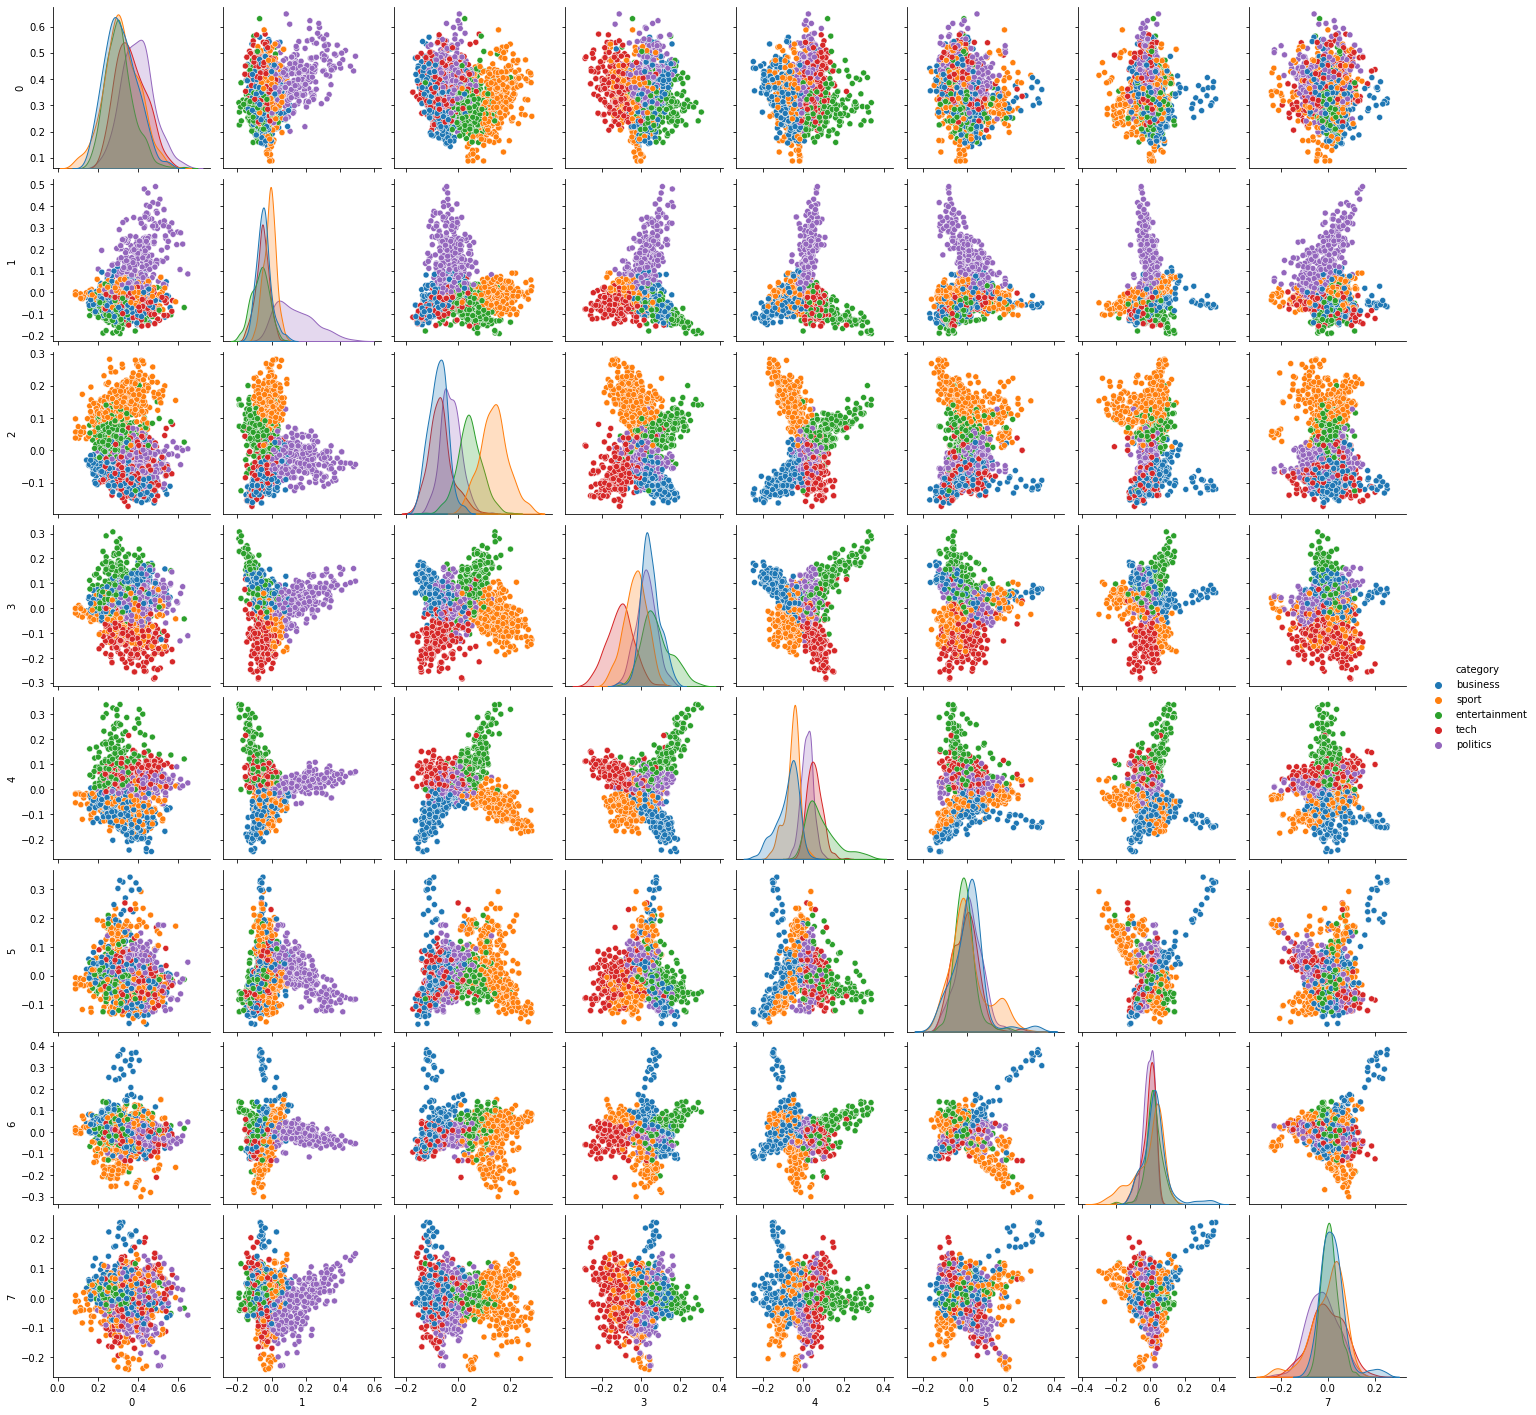

In [18]:
sns.pairplot(text_vectors1,hue="category")

- From the pairplot, I find that the different classes will try to cluster in different locations in the pairplot. I think in that way, different categories have the largest variance.
- the distribution of each category is symmetric and looks normal.

k-NN classifier with 5 neighbors on the SVD-transformed article texts

In [19]:
svd_knn_pipe = Pipeline([
    ('word_vec', TfidfVectorizer()),
    ('svd', TruncatedSVD(8)),
    ('model',KNeighborsClassifier(n_neighbors=5))
    
])
svd_knn_pipe.fit(train['text'], train['category'])

Pipeline(steps=[('word_vec', TfidfVectorizer()),
                ('svd', TruncatedSVD(n_components=8)),
                ('model', KNeighborsClassifier())])

In [20]:
accuracy_score(train['category'],svd_knn_pipe.predict(train['text']))

0.9617977528089887

In [21]:
accuracy_score(test['category'],svd_knn_pipe.predict(test['text']))

0.9213483146067416

### Summarizing Classifier Accuracy (10%)¶

we have four different classifers including bayes_pipe,knn_pipe, GS_knn_pipe,svd_knn_pipe

- I make a dataframe of train and test accuracy of these all models

In [22]:
acc=pd.DataFrame({'Model':['naïve Bayes','KNN','KNN+GS','KNN+DR'],
                  
                  'Train_ACC':[accuracy_score(train['category'],bayes_pipe.predict(train['text'])),
                               accuracy_score(train['category'],knn_pipe.predict(train['text'])),
                               accuracy_score(train['category'],GS_knn_pipe.predict(train['text'])),
                               accuracy_score(train['category'],svd_knn_pipe.predict(train['text']))],
                  
                  'Test_ACC':[accuracy_score(test['category'],bayes_pipe.predict(test['text'])),
                             accuracy_score(test['category'],knn_pipe.predict(test['text'])),
                             accuracy_score(test['category'],GS_knn_pipe.predict(test['text'])),
                             accuracy_score(test['category'],svd_knn_pipe.predict(test['text']))]
    
    
    
})
acc

,Model,Train_ACC,Test_ACC
0,naïve Bayes,0.992697,0.979775
1,KNN,0.950562,0.892135
2,KNN+GS,0.950562,0.892135
3,KNN+DR,0.961798,0.921348


in my view, a good way to compare overfitting from different models is the performance difference between the train accuracy and test accuracy.

as we can see below, the naïve Bayes has the lowest diff value, so it is the less overfitting method.

In [23]:
acc['diff']=acc['Train_ACC']-acc['Test_ACC']
acc

,Model,Train_ACC,Test_ACC,diff
0,naïve Bayes,0.992697,0.979775,0.012921
1,KNN,0.950562,0.892135,0.058427
2,KNN+GS,0.950562,0.892135,0.058427
3,KNN+DR,0.961798,0.921348,0.040449


let's show the results with plot

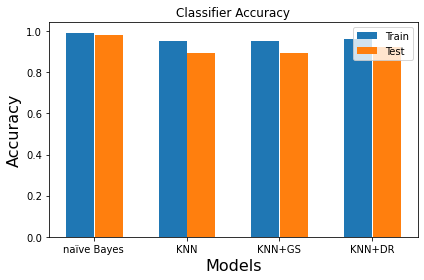

In [24]:
labels = acc['Model'].values.tolist()
a = acc['Train_ACC'].values.tolist()
b = acc['Test_ACC'].values.tolist()

x = np.arange(len(labels))
width = 0.3 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width*2, a, width, label='Train')
rects2 = ax.bar(x - width+0.01, b, width, label='Test')

ax.set_ylabel('Accuracy', fontsize=16)
ax.set_xlabel('Models', fontsize=16)
ax.set_title('Classifier Accuracy')
ax.set_xticks(x-0.45)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

From the plot, we can see that the naive bayes' train accuracy and test accuracy is closer than other classifers. and also it is the highest among them.

Use GridSearchCV to simultaneously pick a good number of dimensions for the SVD and a good number of neighbors.

In [25]:
GS_svd_knn_pipe = Pipeline([
    ('word_vec', TfidfVectorizer(stop_words='english',lowercase=True)),
    
    ('svd',GridSearchCV(TruncatedSVD(),{'n_components':[5,6,7,8,9,10,11,12,20,22,25]},
                        n_jobs=6,
                       scoring=make_scorer(accuracy_score))),
    
    #('svd', TruncatedSVD(8)),
    
    ('model',GridSearchCV(KNeighborsClassifier(), {
    'n_neighbors': [1, 2, 3, 5, 7, 10]
}, n_jobs=6,scoring=make_scorer(accuracy_score)))
    #('model',KNeighborsClassifier(n_neighbors=5))
    
])
GS_svd_knn_pipe.fit(train['text'], train['category'])

Pipeline(steps=[('word_vec', TfidfVectorizer(stop_words='english')),
                ('svd',
                 GridSearchCV(estimator=TruncatedSVD(), n_jobs=6,
                              param_grid={'n_components': [5, 6, 7, 8, 9, 10,
                                                           11, 12, 20, 22,
                                                           25]},
                              scoring=make_scorer(accuracy_score))),
                ('model',
                 GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=6,
                              param_grid={'n_neighbors': [1, 2, 3, 5, 7, 10]},
                              scoring=make_scorer(accuracy_score)))])

I find that if I add 1,2,3,4 in the n_components of the TruncatedSVD(). the best_params_ would choose {'n_components': 1}, and the train accuracy would be very high, almost 100%, while the test accuracy would be very low. I think it is because the extremely overfitting.

In [26]:
GS_svd_knn_pipe.named_steps['svd'].best_params_

{'n_components': 5}

In [27]:
GS_svd_knn_pipe.named_steps['model'].best_params_

{'n_neighbors': 5}

In [28]:
accuracy_score(train['category'],GS_svd_knn_pipe.predict(train['text']))

0.9561797752808989

In [29]:
accuracy_score(test['category'],GS_svd_knn_pipe.predict(test['text']))

0.9415730337078652

I think the accuracy becomes higher in the KNN classifier. 

As we can see from the test accuracy, it is higher in test accuracy than other knn classifiers before, and the difference between train accuracy and test accuracy is small. it means that the overfitting is lower in this model.

### Clustering (20%)

In [30]:
from sklearn.cluster import KMeans

k-means model with 5 clusters, using TF-IDF vectors

In [31]:
kmeans_pipe = Pipeline([
    ('word_vec', TfidfVectorizer(stop_words='english', max_features=10000)),
    ('model',KMeans(n_clusters=5))
])


In [32]:
kmeans_pipe.fit(train['text'])

Pipeline(steps=[('word_vec',
                 TfidfVectorizer(max_features=10000, stop_words='english')),
                ('model', KMeans(n_clusters=5))])

In [33]:
catecluster=kmeans_pipe.predict(train['text'])

- add the clustering result to the dataframe. in order to compare with the ground truth to get the accuracy.

In [34]:
train['cluster'] = catecluster.tolist()

-  the distribution of document categories within each clusters

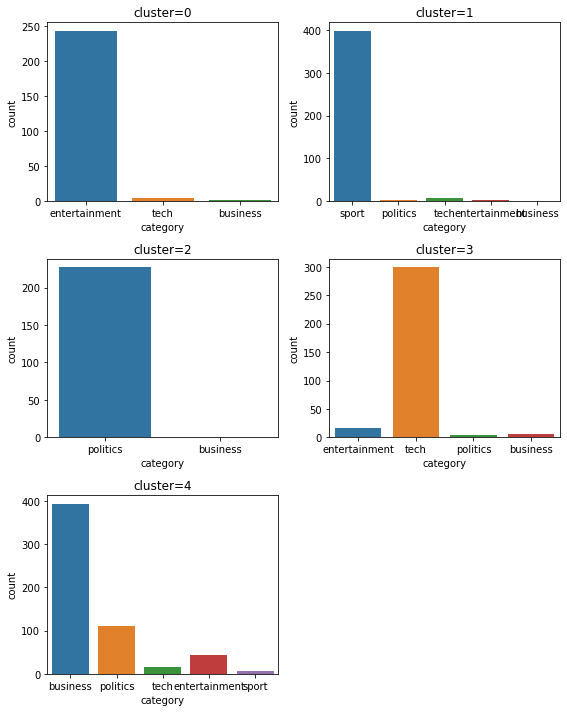

In [35]:
f0=plt.figure(figsize=(8, 10))
f0.add_subplot(3,2,1)
sns.countplot(train.loc[catecluster == 0, 'category'])
plt.title('cluster=0')
f0.add_subplot(3,2,2)
sns.countplot(train.loc[catecluster == 1, 'category'])
plt.title('cluster=1')
f0.add_subplot(3,2,3)
sns.countplot(train.loc[catecluster == 2, 'category'])
plt.title('cluster=2')
f0.add_subplot(3,2,4)
sns.countplot(train.loc[catecluster == 3, 'category'])
plt.title('cluster=3')
f0.add_subplot(3,2,5)
sns.countplot(train.loc[catecluster == 4, 'category'])
plt.title('cluster=4')
f0.tight_layout()

- from the plot, we can find that in Cluster 0, the category: 'politic' is the most common; Cluster 1, the category: 'business' is the most common;Cluster 2, the category: 'entertament' is the most common;Cluster 3, the category: 'tech' is the most common; Cluster 4, the category: 'sport' is the most common

this is mainly used for calculating the accuracy. 

- depend on the mode in each cluster, I change the name of the cluster to the mode's name.
- For example, in cluster 0, the mode is politics as catefory politics counts most in clusting 0, so I change the name of cluster 0 to 'politics'. do the same things to other clusters.

In [36]:
for i in range(5):
    train.loc[train['cluster']==i,
              'cluster2cate']=train.loc[catecluster == i, 
            'category'].mode().to_string().replace(' ','').translate(str.maketrans('', '', digits))
    
# train.loc[train['cluster']==0,'cluster2cate']=train.loc[catecluster == 0, 'category'].mode().to_string().replace(' ','').translate(str.maketrans('', '', digits))
# train.loc[train['cluster']==1,'cluster2cate']=train.loc[catecluster == 1, 'category'].mode().to_string().replace(' ','').translate(str.maketrans('', '', digits))
# train.loc[train['cluster']==2,'cluster2cate']=train.loc[catecluster == 2, 'category'].mode().to_string().replace(' ','').translate(str.maketrans('', '', digits))
# train.loc[train['cluster']==3,'cluster2cate']=train.loc[catecluster == 3, 'category'].mode().to_string().replace(' ','').translate(str.maketrans('', '', digits))
# train.loc[train['cluster']==4,'cluster2cate']=train.loc[catecluster == 4, 'category'].mode().to_string().replace(' ','').translate(str.maketrans('', '', digits))

In [37]:
confusion_matrix(train['category'],train['cluster2cate'])

array([[394,   1,   1,   1,   6],
       [ 43, 243,   0,   2,  16],
       [111,   0, 227,   2,   4],
       [  6,   0,   0, 398,   0],
       [ 16,   4,   0,   6, 299]])

In [38]:
pd.DataFrame(confusion_matrix(train['category'],train['cluster2cate']))

,0,1,2,3,4
0,394,1,1,1,6
1,43,243,0,2,16
2,111,0,227,2,4
3,6,0,0,398,0
4,16,4,0,6,299


In [39]:
accuracy_score(train['category'],train['cluster2cate'])

0.8769662921348315

- then we need to test the model in test data

In [40]:
catecluster=kmeans_pipe.predict(test['text'])
test['cluster'] = catecluster.tolist()

- add the clustering result to the dataframe. in order to compare with the ground truth to get the accuracy.

-  the distribution of document categories within each clusters

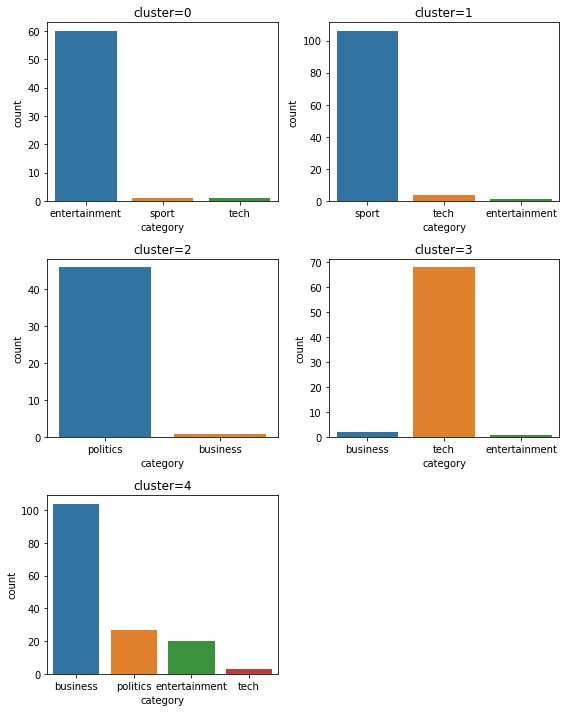

In [41]:
f0=plt.figure(figsize=(8, 10))
f0.add_subplot(3,2,1)
sns.countplot(test.loc[catecluster == 0, 'category'])
plt.title('cluster=0')
f0.add_subplot(3,2,2)
sns.countplot(test.loc[catecluster == 1, 'category'])
plt.title('cluster=1')
f0.add_subplot(3,2,3)
sns.countplot(test.loc[catecluster == 2, 'category'])
plt.title('cluster=2')
f0.add_subplot(3,2,4)
sns.countplot(test.loc[catecluster == 3, 'category'])
plt.title('cluster=3')
f0.add_subplot(3,2,5)
sns.countplot(test.loc[catecluster == 4, 'category'])
plt.title('cluster=4')
f0.tight_layout()

- from the plot, we can find that in Cluster 0, the category: 'politic' is the most common; Cluster 1, the category: 'business' is the most common;Cluster 2, the category: 'entertament' is the most common;Cluster 3, the category: 'tech' is the most common; Cluster 4, the category: 'sport' is the most common

this is mainly used for calculating the accuracy. 

- depend on the mode in each cluster, I change the name of the cluster to the mode's name.
- For example, in cluster 0, the mode is politics as catefory politics counts most in clusting 0, so I change the name of cluster 0 to 'politics'. do the same things to other clusters.

In [42]:
for i in range(5):
    test.loc[test['cluster']==i,
              'cluster2cate']=test.loc[catecluster == i, 
            'category'].mode().to_string().replace(' ','').translate(str.maketrans('', '', digits))
    

In [43]:
confusion_matrix(test['category'],test['cluster2cate'])

array([[104,   0,   1,   0,   2],
       [ 20,  60,   0,   1,   1],
       [ 27,   0,  46,   0,   0],
       [  0,   1,   0, 106,   0],
       [  3,   1,   0,   4,  68]])

In [44]:
accuracy_score(test['category'],test['cluster2cate'])

0.8629213483146068

AS we can see, the results from the train and test are both lower than the supervised method. so I didn't think it did a good job. however, I would say that the difference between train and test accuracy is quite close, which means it did good in overfitting.

#### Repeat with 6 clusters

In [45]:
kmeans2_pipe = Pipeline([
    ('word_vec', TfidfVectorizer(stop_words='english', max_features=10000)),
    ('model',KMeans(n_clusters=6))
])

In [46]:
kmeans2_pipe.fit(train['text'])

Pipeline(steps=[('word_vec',
                 TfidfVectorizer(max_features=10000, stop_words='english')),
                ('model', KMeans(n_clusters=6))])

In [47]:
catecluster2=kmeans2_pipe.predict(train['text'])

this count plot shows counts of numbers in different clustering.

<AxesSubplot:ylabel='count'>

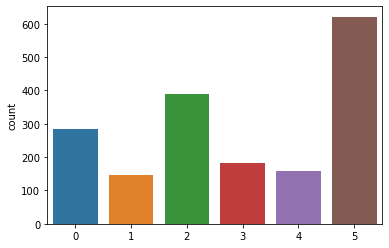

In [48]:
sns.countplot(catecluster2)

- add the clustering result to the dataframe. in order to compare with the ground truth to get the accuracy.

In [49]:
train['cluster2'] = catecluster2.tolist()

-  the distribution of document categories within each clusters

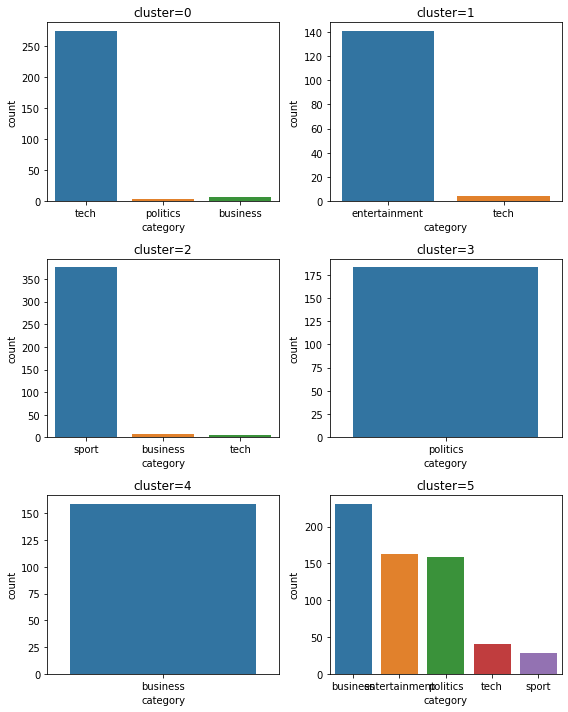

In [50]:
f0=plt.figure(figsize=(8,10))
f0.add_subplot(3,2,1)
sns.countplot(train.loc[catecluster2 == 0, 'category'])
plt.title('cluster=0')
f0.add_subplot(3,2,2)
sns.countplot(train.loc[catecluster2 == 1, 'category'])
plt.title('cluster=1')
f0.add_subplot(3,2,3)
sns.countplot(train.loc[catecluster2 == 2, 'category'])
plt.title('cluster=2')
f0.add_subplot(3,2,4)
sns.countplot(train.loc[catecluster2 == 3, 'category'])
plt.title('cluster=3')
f0.add_subplot(3,2,5)
sns.countplot(train.loc[catecluster2 == 4, 'category'])
plt.title('cluster=4')
f0.add_subplot(3,2,6)
sns.countplot(train.loc[catecluster2 == 5, 'category'])
plt.title('cluster=5')
f0.tight_layout()

- from the plot, we can find that 
1. in Cluster 0, the category: 'entertament' is the most common; 
2. Cluster 1, the category: 'politics' is the most common;
3. Cluster 2, the category: 'sport' is the most common;
4. Cluster 3, the category: 'business' is the most common; 
5. Cluster 4, the category: 'business' is the most common; 
5. Cluster 5, the category: 'tech' is the most common;

this is mainly used for calculating the accuracy. 

- depend on the mode in each cluster, I change the name of the cluster to the mode's name.
- For example, in cluster 0, the mode is politics as catefory politics counts most in clusting 0, so I change the name of cluster 0 to 'politics'. do the same things to other clusters.

In [51]:
for j in range(6):
    train.loc[train['cluster2']==j,
    'cluster2cate2']=train.loc[catecluster2 == j, 
    'category'].mode().to_string().replace(' ','').translate(str.maketrans('', '', digits))
# train.loc[train['cluster2']==0,'cluster2cate2']=train.loc[catecluster2 == 0, 'category'].mode().to_string().replace(' ','').translate(str.maketrans('', '', digits))
# train.loc[train['cluster2']==1,'cluster2cate2']=train.loc[catecluster2 == 1, 'category'].mode().to_string().replace(' ','').translate(str.maketrans('', '', digits))
# train.loc[train['cluster2']==2,'cluster2cate2']=train.loc[catecluster2 == 2, 'category'].mode().to_string().replace(' ','').translate(str.maketrans('', '', digits))
# train.loc[train['cluster2']==3,'cluster2cate2']=train.loc[catecluster2 == 3, 'category'].mode().to_string().replace(' ','').translate(str.maketrans('', '', digits))
# train.loc[train['cluster2']==4,'cluster2cate2']=train.loc[catecluster2 == 4, 'category'].mode().to_string().replace(' ','').translate(str.maketrans('', '', digits))
# train.loc[train['cluster2']==5,'cluster2cate2']=train.loc[catecluster2 == 5, 'category'].mode().to_string().replace(' ','').translate(str.maketrans('', '', digits))

In [52]:
confusion_matrix(train['category'],train['cluster2cate2'])

array([[390,   0,   0,   7,   6],
       [163, 141,   0,   0,   0],
       [158,   0, 183,   0,   3],
       [ 28,   0,   0, 376,   0],
       [ 41,   4,   0,   5, 275]])

In [53]:
accuracy_score(train['category'],train['cluster2cate2'])

0.7668539325842697

then we calculate the results on test

In [54]:
catecluster2=kmeans2_pipe.predict(test['text'])

- add the clustering result to the dataframe. in order to compare with the ground truth to get the accuracy.

In [55]:
test['cluster2'] = catecluster2.tolist()

-  the distribution of document categories within each clusters

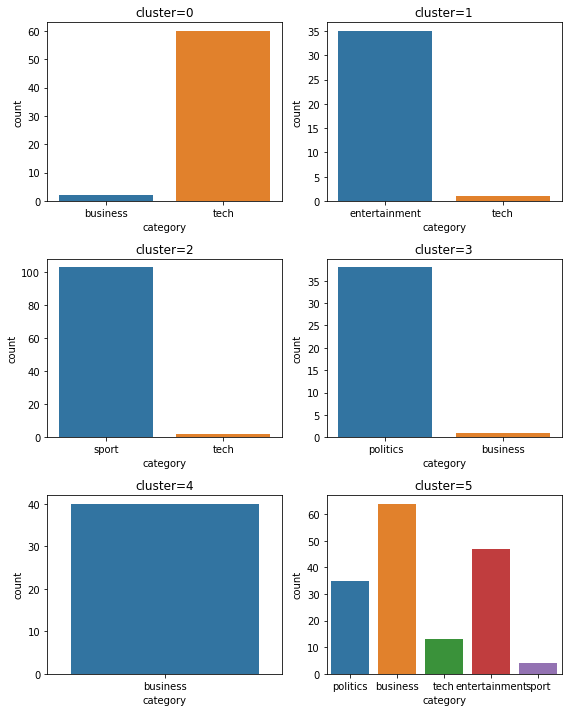

In [56]:
f0=plt.figure(figsize=(8,10))
f0.add_subplot(3,2,1)
sns.countplot(test.loc[catecluster2 == 0, 'category'])
plt.title('cluster=0')
f0.add_subplot(3,2,2)
sns.countplot(test.loc[catecluster2 == 1, 'category'])
plt.title('cluster=1')
f0.add_subplot(3,2,3)
sns.countplot(test.loc[catecluster2 == 2, 'category'])
plt.title('cluster=2')
f0.add_subplot(3,2,4)
sns.countplot(test.loc[catecluster2 == 3, 'category'])
plt.title('cluster=3')
f0.add_subplot(3,2,5)
sns.countplot(test.loc[catecluster2 == 4, 'category'])
plt.title('cluster=4')
f0.add_subplot(3,2,6)
sns.countplot(test.loc[catecluster2 == 5, 'category'])
plt.title('cluster=5')
f0.tight_layout()

- from the plot, we can find that 
1. in Cluster 0, the category: 'entertament' is the most common; 
2. Cluster 1, the category: 'politics' is the most common;
3. Cluster 2, the category: 'sport' is the most common;
4. Cluster 3, the category: 'business' is the most common; 
5. Cluster 4, the category: 'business' is the most common; 
5. Cluster 5, the category: 'tech' is the most common;

this is mainly used for calculating the accuracy. 

- depend on the mode in each cluster, I change the name of the cluster to the mode's name.
- For example, in cluster 0, the mode is politics as catefory politics counts most in clusting 0, so I change the name of cluster 0 to 'politics'. do the same things to other clusters.

In [57]:
for j in range(6):
    test.loc[test['cluster2']==j,
    'cluster2cate2']=test.loc[catecluster2 == j, 
    'category'].mode().to_string().replace(' ','').translate(str.maketrans('', '', digits))

In [58]:
confusion_matrix(test['category'],test['cluster2cate2'])

array([[104,   0,   1,   0,   2],
       [ 47,  35,   0,   0,   0],
       [ 35,   0,  38,   0,   0],
       [  4,   0,   0, 103,   0],
       [ 13,   1,   0,   2,  60]])

In [59]:
accuracy_score(test['category'],test['cluster2cate2'])

0.7640449438202247

- the accuracy even becomes worse than 5 clusters. I think the main reason is that the actual categories is 5 kinds. and if we clustered in 6 clusters, then there would be some mistakes in it. and the accuracy would be lower as we can see.

### find the words that are most important for that cluster

it says where in word-space the middle of that cluster is

In [60]:
or_cen = kmeans_pipe.named_steps["model"].cluster_centers_.argsort()[:, ::-1]

In [61]:
#or_cen = kmeans2_pipe.named_steps["model"].cluster_centers_
or_cen

array([[3582, 1123,  934, ..., 5551, 5552,    0],
       [3862, 3195, 7874, ..., 9129, 5791, 3816],
       [6000, 5163, 3097, ..., 6899, 6898, 9999],
       [6618, 5906, 7874, ..., 2436, 6440, 4159],
       [7874, 9964, 6000, ..., 5423, 5421, 4350]])

get the words with the vectorizer’s get_feature_names() method

In [62]:
terms = kmeans_pipe.named_steps["word_vec"].get_feature_names()

In [63]:
terms

['00',
 '000',
 '000m',
 '01',
 '04',
 '05',
 '06',
 '07',
 '10',
 '100',
 '100m',
 '101',
 '102',
 '104',
 '105',
 '10bn',
 '10m',
 '10th',
 '11',
 '110',
 '115',
 '11bn',
 '11th',
 '12',
 '120',
 '120m',
 '125',
 '12bn',
 '12th',
 '13',
 '130',
 '133',
 '13m',
 '14',
 '140',
 '144',
 '149',
 '14bn',
 '14m',
 '15',
 '150',
 '1500m',
 '150m',
 '155',
 '157',
 '158',
 '15m',
 '15th',
 '16',
 '162',
 '167',
 '16bn',
 '17',
 '170',
 '178',
 '17m',
 '18',
 '180',
 '180bn',
 '189',
 '18m',
 '18th',
 '19',
 '190',
 '1900',
 '1945',
 '1948',
 '1950s',
 '1956',
 '1957',
 '1960s',
 '1964',
 '1965',
 '1967',
 '1968',
 '1969',
 '1970',
 '1970s',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1980s',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1990s',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '19bn',
 '19m',
 '19th',
 '1bn',
 '1m',
 '20',
 '200',
 '2000',
 '2001',
 '

In [64]:
for i in range(5):
    common_words = []
    for j in or_cen[i, :20]:
        common_words.append(terms[j])
    print(f"Cluster no {i} words: {', '.join(common_words)}")

Cluster no 0 words: film, best, awards, award, band, festival, actor, year, album, oscar, films, star, said, comedy, won, actress, number, tv, music, director
Cluster no 1 words: game, england, said, win, team, players, cup, match, injury, world, ireland, play, season, final, club, time, coach, year, wales, france
Cluster no 2 words: mr, labour, election, blair, party, said, brown, government, howard, minister, tax, tory, tories, prime, chancellor, people, leader, lib, plans, campaign
Cluster no 3 words: people, mobile, said, music, technology, software, users, digital, phone, games, broadband, video, net, microsoft, computer, online, use, phones, mr, new
Cluster no 4 words: said, year, mr, economy, growth, government, oil, bank, company, sales, market, economic, firm, shares, new, 2004, china, prices, deal, dollar


I think these words make sense in light of the documents in that clusters. mode means the biggest count in one cluster.

In cluster 0, mode is the politics, and the word labour, election make sense.

In cluster 1, mode is the business, and the economy, growth make sense.

In cluster 2, mode is the entertament, and the word film, best, awards make sense.

In cluster 3, mode is tech, the second largest is entertament, and the word said, music, people, mobile make sense.

In cluster 4, mode is sport, the word game, england, win make sense.


## Reflection (10%)


First, you can not use test data to train your model like change the parameters, you can only do that in train data. it is better to get a tuning data to improve the performance of the model. but because in this assignment, the data scale is not big, so I didn't do that. I'm afraid the model would be not train fully because lack of data.

Second, I find in surpervised methods, the naive bayes is always performs better than KNN. I don't think it is because we didn't find the best parameters in KNN, it is due to the theory. and I think the naive bayes is good in nature language learning than KNN.

third, I think the unsurpervised method performs not so good as the surpervised model. I mainly think it is because the unsurpervised model didn't need the labels on the data, and it lacks something as the surpervised model, so the accuracy is not so good as the surpervised method. However, when the data has no label or it is time comsuming to label all the training data, the unsupervised method would be definitely a nice way to do the classification.

by the way, I haven't do the nature language processing before, but I think it is very similar to the dataset we did before, only the object changes to the word. I think we can also use other classification models on NLP also.